# Subjective Verbs

This notebook seeks to merge ideas in the 2 SV pair notebooks.

<div class="alert alert-block alert-info"> 
    <p>A note about the naming of variables below:</p>
    <ul>
        <li><code>m</code> and <code>w</code> represent the subcorpus, men or women speakers</li>
        <li><code>pp</code> stands for personal pronouns, usually "he," "she," and "I" here.
        <li><code>svo</code> signifies that the complete SVO-triplet is used</li>
        <li><code>sv</code> signifies that just the subject-verb pairs are being used</li>
    </ul>   
</div>

What we want to explore is both the usual ways that speakers (men or women) pair the pronouns *he*, *she*, *i* with verbs and also, perhaps, the significant pairings. The usual way can be approached via **counts**, which we have visualized in a separate notebook with Sankey plots.

Relative frequencies would let us compare across the two subcorpora ... or would this be approached better by some form of TF-IDF? (And would we need to determine some sort of lower threshold of the number of sentences in which a verb must occur? We're not interested in verb only used in a single sentence but verbs used often in a pairing in one subcorpus and not in the other.)

In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# LOAD DATAFRAMES
# the `lem` suffix indicates the verbs have been lemmatized
svos_m = pd.read_csv("../output/svos_m_lem.csv", index_col=0)
svos_w = pd.read_csv("../output/svos_w_lem.csv", index_col=0)

# Save the SVO count for each corpus for calculating relative frequencies
m_svo_count = svos_m.shape[0]
w_svo_count = svos_w.shape[0]

# Output something to check our efforts
print(m_svo_count, w_svo_count)

80460 26610


## SV Pairs with "She", "He", and "I"

In [2]:
# Create a list of the pronouns we want to see
pronouns = ["he", "she", "i"]

# Function to retrive the count the number of times subjects,
# here a list of pronouns, are paired with verbs
def svPairs (df, pplist):    
    temp = df[df["subject"].isin(
        pplist)].value_counts(
        subset=['subject', 'verb']).reset_index()
    # Re-label the new column from "0" to something human-readable
    temp.rename(columns={0:'v_freq'}, inplace=True)
    # Add a column with relative frequency
    temp['v_rfreq'] = temp['v_freq'] / df.shape[0]
    return temp

In [3]:
m_pp_v = svPairs(svos_m, pronouns)
w_pp_v = svPairs(svos_w, pronouns)

print(m_pp_v.shape)
print(w_pp_v.shape)

# m_pp_v.to_csv("../output/m_pp_v.csv")
# w_pp_v.to_csv("../output/w_pp_v.csv")

(1723, 4)
(1069, 4)


In [4]:
m_pp_v.head()

,subject,verb,v_freq,v_rfreq
0,i,have,1318,0.016381
1,i,want,1210,0.015039
2,i,go,1076,0.013373
3,i,do,650,0.008079
4,i,get,586,0.007283


## Subjects as Verb Features

In the cells below, we … 

1. **create 6 distinct dataframes**, one each for men and women speakers and the three pronouns.
2. **transpose each "subjective" dataframe** into a single row with the verbs associated with as columns and their relative frequencies as values.
3. **stack those rows** to get a unified dataframe with all 6 subject positions and verbs associated with them.
4. **transpose unified dataframe** to have the features as rows and the speaker-pronoun documents as columns (so we can do some math on the features). I.e., `verbs` dataframe below.

In [5]:
# function to filter SVOs for 
def filterdrop (df, pronoun, threshold):
    dftemp = df.loc[(df['subject'] == pronoun)]
    dftemp = dftemp.drop(columns=['subject', 'v_rfreq'])
    dftemp = dftemp[dftemp.v_freq > threshold]
    return dftemp

In [6]:
# Create our pronoun-verb dataframes for he, she, i
m_he = filterdrop(m_pp_v, "he", 1)
w_he = filterdrop(w_pp_v, "he", 1)

m_she = filterdrop(m_pp_v, "she", 1)
w_she = filterdrop(w_pp_v, "she", 1)

m_i = filterdrop(m_pp_v, "i", 1)
w_i = filterdrop(w_pp_v, "i", 1)

# Print counts & preview a dataframe
print(f"m_he:  {m_he.shape[0]}, w_he:  {w_he.shape[0]}")
print(f"m_she: {m_she.shape[0]}, w_she: {w_she.shape[0]}")
print(f"m_i:   {m_i.shape[0]}, w_i:   {w_i.shape[0]}")
print("\n w_i looks like:")
print(w_i.head())

m_he:  218, w_he:  95
m_she: 94, w_she: 85
m_i:   522, w_i:   301

 w_i looks like:
   verb  v_freq
0  have     586
1  want     424
2    go     330
3    do     226
4   get     203


In [7]:
# This function takes the two columns of verb and count,
# transposes them, into a dataframe of a single row,
# with the verb as the column name
def makestackable (df, indexname):
    df_T = df.transpose()
    df_T.columns = df_T.iloc[0]
    df_T.drop(index=df_T.index[0], axis=0, inplace=True)
    df_T.index = [indexname]
    return df_T

# We use the function to create 6 dataframes
m_it = makestackable(m_i, "m_i")
w_it = makestackable(w_i, "w_i")
m_het = makestackable(m_he, "m_he")
w_het = makestackable(w_he, "w_he")
m_shet = makestackable(m_she, "m_she")
w_shet = makestackable(w_she, "w_she")

# ... that we then "stack" together 
# with the verbs as columns and the counts as values
concatenated = pd.concat([w_it, m_it, w_het, m_het, w_shet, m_shet])
concatenated.fillna(0, inplace=True)

# View the results
concatenated.head(6)

verb,have,want,go,do,get,tell,like,know,start,love,...,brush,feed,wield,lower,acknowledge,book,stab,volunteer,march,clear
w_i,586,424,330,226,203,169,160,154,145,137,...,0,0,0,0,0,0,0,0,0,0
m_i,1318,1210,1076,650,586,326,462,274,377,271,...,0,0,0,0,0,0,0,0,0,0
w_he,80,20,32,29,19,16,7,4,12,4,...,0,0,0,0,0,0,0,0,0,0
m_he,232,71,78,111,90,58,14,27,42,5,...,0,0,0,0,0,0,0,0,0,0
w_she,63,11,22,33,20,18,6,6,9,10,...,3,3,2,0,0,0,0,0,0,0
m_she,94,32,34,41,24,20,5,10,17,4,...,0,0,0,3,2,2,2,2,2,2


In [8]:
# Having done the work above, we now rotate the dataframe again
# in order to have the speaker-pronouns as columns and the verbs as rows
verbs = concatenated.transpose()
verbs.head()

,w_i,m_i,w_he,m_he,w_she,m_she
verb,,,,,,
have,586,1318,80,232,63,94
want,424,1210,20,71,11,32
go,330,1076,32,78,22,34
do,226,650,29,111,33,41
get,203,586,19,90,20,24


### The TF-IDF Part

We are going to treat each of the speaker-pronoun columns as a document, so that we can explore which verbs are evenly distributed across the pairings and which differentiate the actions available to a subject.

#### With Relative Frequency of Terms within Pseudo-Documents

In [9]:
# We need totals both by term (rows) and by document (columns)
# A peculiarity of pandas means we need to get rows first, then columns

# Totals per verb:
verbs["total"] = verbs.sum(axis = 1)

# Totals per document
doc_totals = verbs.sum(axis = 0)

# To hold our totals
new_verbs = verbs.copy()

# View the total number of s-v pairs per pronoun
doc_totals

w_i       5884
m_i      14998
w_he       606
m_he      2252
w_she      507
m_she      697
total    24944
dtype: int64

In [10]:
# Get TF by "document"
verbs_rel = verbs/doc_totals

In [11]:
verbs_rel.style.background_gradient(axis=None, cmap='icefire')

,w_i,m_i,w_he,m_he,w_she,m_she,total
verb,,,,,,,
have,0.099592,0.087878,0.132013,0.103020,0.124260,0.134864,0.095133
want,0.072060,0.080677,0.033003,0.031528,0.021696,0.045911,0.070879
go,0.056084,0.071743,0.052805,0.034636,0.043393,0.048780,0.063021
do,0.038409,0.043339,0.047855,0.049290,0.065089,0.058824,0.043698
get,0.034500,0.039072,0.031353,0.039964,0.039448,0.034433,0.037765
tell,0.028722,0.021736,0.026403,0.025755,0.035503,0.028694,0.024335
like,0.027192,0.030804,0.011551,0.006217,0.011834,0.007174,0.026219
know,0.026173,0.018269,0.006601,0.011989,0.011834,0.014347,0.019043
start,0.024643,0.025137,0.019802,0.018650,0.017751,0.024390,0.024134


In [12]:
# Reclaim our totals:
verbs_rel["total"] = new_verbs["total"]
verbs_rel.head()

,w_i,m_i,w_he,m_he,w_she,m_she,total
verb,,,,,,,
have,0.099592,0.087878,0.132013,0.103020,0.124260,0.134864,2373
want,0.072060,0.080677,0.033003,0.031528,0.021696,0.045911,1768
go,0.056084,0.071743,0.052805,0.034636,0.043393,0.048780,1572
do,0.038409,0.043339,0.047855,0.049290,0.065089,0.058824,1090
get,0.034500,0.039072,0.031353,0.039964,0.039448,0.034433,942


In [13]:
# establish that we only want to work on the counts
# for each pronoun and not the total
cols = verbs_rel.columns
cols = list(cols)[:-1]

# the TFIDF part
for col in cols:
    verbs_rel[col] = (1/new_verbs["total"])*verbs_rel[col]

In [14]:
verbsy = verbs_rel.drop('total', axis=1)
verbsy.style.background_gradient(axis=None, cmap='twilight')

,w_i,m_i,w_he,m_he,w_she,m_she
verb,,,,,,
have,0.000042,0.000037,0.000056,0.000043,0.000052,0.000057
want,0.000041,0.000046,0.000019,0.000018,0.000012,0.000026
go,0.000036,0.000046,0.000034,0.000022,0.000028,0.000031
do,0.000035,0.000040,0.000044,0.000045,0.000060,0.000054
get,0.000037,0.000041,0.000033,0.000042,0.000042,0.000037
tell,0.000047,0.000036,0.000043,0.000042,0.000058,0.000047
like,0.000042,0.000047,0.000018,0.000010,0.000018,0.000011
know,0.000055,0.000038,0.000014,0.000025,0.000025,0.000030
start,0.000041,0.000042,0.000033,0.000031,0.000029,0.000041


In [15]:
thirdpp = verbs_rel.drop(['total', 'w_i', 'm_i'], axis=1)
thirdpp.style.background_gradient(axis=None, cmap='icefire')

,w_he,m_he,w_she,m_she
verb,,,,
have,0.000056,0.000043,0.000052,0.000057
want,0.000019,0.000018,0.000012,0.000026
go,0.000034,0.000022,0.000028,0.000031
do,0.000044,0.000045,0.000060,0.000054
get,0.000033,0.000042,0.000042,0.000037
tell,0.000043,0.000042,0.000058,0.000047
like,0.000018,0.000010,0.000018,0.000011
know,0.000014,0.000025,0.000025,0.000030
start,0.000033,0.000031,0.000029,0.000041


In [16]:
# Set the tolerance

eps = 5*10e-7

print(eps)

4.9999999999999996e-06


In [17]:
# See which values are above the tolerance

third_cuts = (thirdpp >= eps)

In [18]:
# Create a set of indices that tells you which rows
# have at least one value above the tolerance
#    np.sum(..., axis = 1) sums over the column
#    ... > 0 tells us which rows have at least one above tol
inds = np.sum(third_cuts, axis = 1) > 0

In [19]:
# sanity check
inds

verb
have         True
want         True
go           True
do           True
get          True
             ... 
book         True
stab         True
volunteer    True
march        True
clear        True
Length: 621, dtype: bool

In [20]:
# use the above indices to select just those rows with 
# at least once above the tolerance

# Note this will leave us with verbs whose "weight" is 
# not nearly completely in the "i" verbs

little_third = thirdpp[inds]

In [21]:
# make pretty

little_third.style.background_gradient(axis=None, cmap='icefire')

,w_he,m_he,w_she,m_she
verb,,,,
have,0.000056,0.000043,0.000052,0.000057
want,0.000019,0.000018,0.000012,0.000026
go,0.000034,0.000022,0.000028,0.000031
do,0.000044,0.000045,0.000060,0.000054
get,0.000033,0.000042,0.000042,0.000037
tell,0.000043,0.000042,0.000058,0.000047
like,0.000018,0.000010,0.000018,0.000011
know,0.000014,0.000025,0.000025,0.000030
start,0.000033,0.000031,0.000029,0.000041


<AxesSubplot:ylabel='verb'>

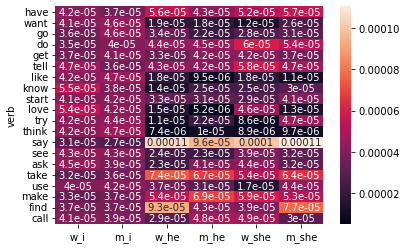

In [22]:
sns.heatmap(verbsy.head(20), annot=True)

#### With Raw Count of Terms

In [23]:
verbs_raw = verbs.copy()
verbs_raw["total"] = new_verbs["total"]
verbs_raw.head()

cols = verbs_raw.columns
cols = list(cols)[:-1]

# the TFIDF part
for col in cols:
    verbs_raw[col] = (1/new_verbs["total"])*verbs_raw[col]

In [24]:
verbs_raw = verbs_raw.drop('total', axis=1)
verbs_raw.style.background_gradient(axis=None, cmap='twilight')

,w_i,m_i,w_he,m_he,w_she,m_she
verb,,,,,,
have,0.246945,0.555415,0.033713,0.097767,0.026549,0.039612
want,0.239819,0.684389,0.011312,0.040158,0.006222,0.018100
go,0.209924,0.684478,0.020356,0.049618,0.013995,0.021628
do,0.207339,0.596330,0.026606,0.101835,0.030275,0.037615
get,0.215499,0.622081,0.020170,0.095541,0.021231,0.025478
tell,0.278418,0.537068,0.026359,0.095552,0.029654,0.032949
like,0.244648,0.706422,0.010703,0.021407,0.009174,0.007645
know,0.324211,0.576842,0.008421,0.056842,0.012632,0.021053
start,0.240864,0.626246,0.019934,0.069767,0.014950,0.028239


### Weighted Class TF-IDF

[How to correctly use TF-IDF with imbalanced data — DeepwizAI](https://www.deepwizai.com/projects/how-to-correctly-use-tf-idf-with-imbalanced-data)

### TF-IDF with Normalized Frequencies

The cell below is set to **Raw-NBconvert** for the time being so that it does not run with the rest of the notebook.